# Basic Classifier using InferDotNet

## Introduction

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy import special
import numpy as np

In [2]:
# Gaussian CDF
def cdf(x,mu,sig):
    return 0.5*(1+special.erf((x-mu)/(sig*np.sqrt(2))))

### Config

In [3]:
data_dir = Path('../data')
input_dataset = data_dir/'iris.csv'
output_dataset = data_dir/'iris-one-feature.csv'
model_output = data_dir/'model-output.csv'

### Data Acquisition

In [4]:
df = pd.read_csv(input_dataset)

# We subset the data to only have 
df_2_class = df[df['class'].\
    isin(['Iris-virginica', 'Iris-setosa'])].copy()

In [5]:
df.columns

Index(['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class'], dtype='object')

In [6]:
df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

<AxesSubplot:xlabel='sepallength', ylabel='sepalwidth'>

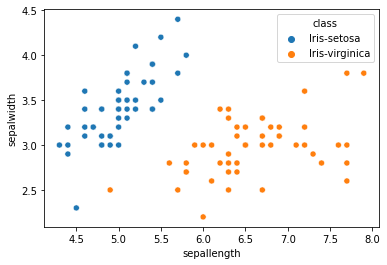

In [7]:
sns.scatterplot(data=df_2_class,
x='sepallength', 
y='sepalwidth', 
hue='class')

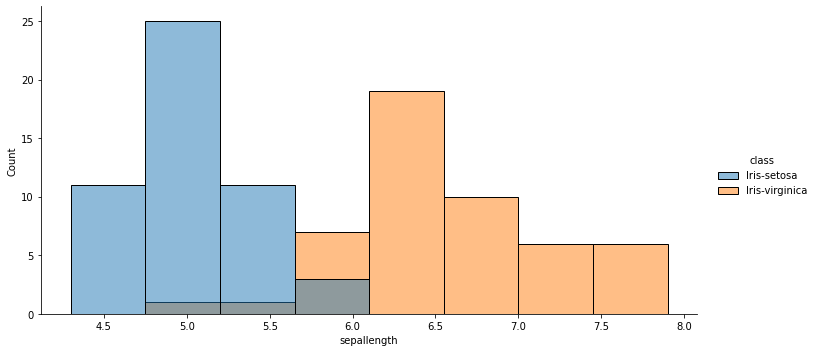

In [8]:
f = sns.displot(data=df_2_class,
x='sepallength',
aspect=2,
hue='class')
f.fig.savefig(Path('./sepal-length-dist.jpg'))

In [9]:
df_2_class.loc[df_2_class['class'] == 'Iris-setosa', 'is_setosa'] = 1
df_2_class.loc[df_2_class['class'] == 'Iris-virginica', 'is_setosa'] =  0
# df_2_class['class'].map({'Iris-setosa':1, 'Iris-virginica':0})

In [10]:
from sklearn.preprocessing import StandardScaler

In [22]:
# scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()
df_2_class.sepallength = scaler.fit_transform(df_2_class.sepallength.values.reshape(-1,1)).flatten()

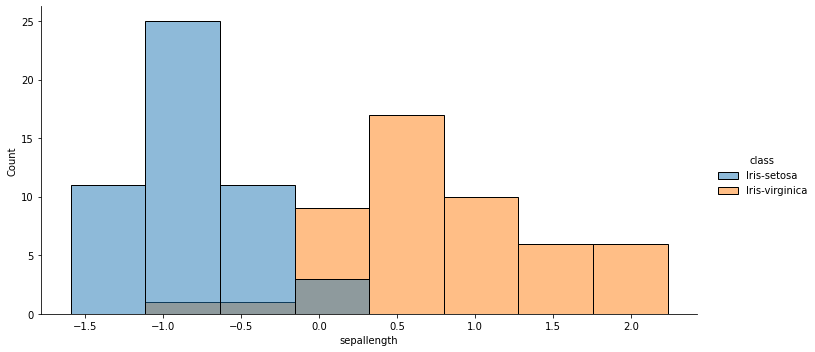

In [23]:
f = sns.displot(data=df_2_class,
x='sepallength',
aspect=2,
hue='class')
f.fig.savefig(Path('./sepal-length-dist-scaled.jpg'))

In [24]:
df_2_class[['sepallength', 'is_setosa']].\
    to_csv(output_dataset,
    header=False,
    sep='|',
    index=False)

## Run Model

In [32]:
cmd = f'dotnet run --project ../model/ ../data/ iris-one-feature.csv'

In [33]:
!{cmd}

======Compiling model...done.
Iterating: 
.........|.........|.........|.........|.........| 50
Gaussian(1.121e-17, 5.552e-33)
Gaussian(8.288, 1.624)
=

In [34]:
df_results = pd.read_csv(data_dir/'results.csv', sep=';')
df_results

,variable,mean,variance
0,postWeight,1.121123e-17,5.552429e-33
1,postThreshold,8.288272e+00,1.623967e+00


In [35]:
df_results.columns

Index(['variable', 'mean', 'variance'], dtype='object')

In [36]:
postWeightMean = df_results[df_results.variable == "postWeight"]['mean'].values[0]
postWeightVariance = df_results[df_results.variable == "postWeight"]['variance'].values[0]
postThresholdMean = df_results[df_results.variable == "postThreshold"]['mean'].values[0]
postThresholdVariance = df_results[df_results.variable == "postThreshold"]['variance'].values[0]
postWeightMean, postWeightVariance,postThresholdMean, postThresholdVariance

(1.1211233541225406e-17,
 5.5524289465690356e-33,
 8.28827179118292,
 1.6239670411534828)

In [37]:
df_2_class['score'] = df_2_class.sepallength * postWeightMean

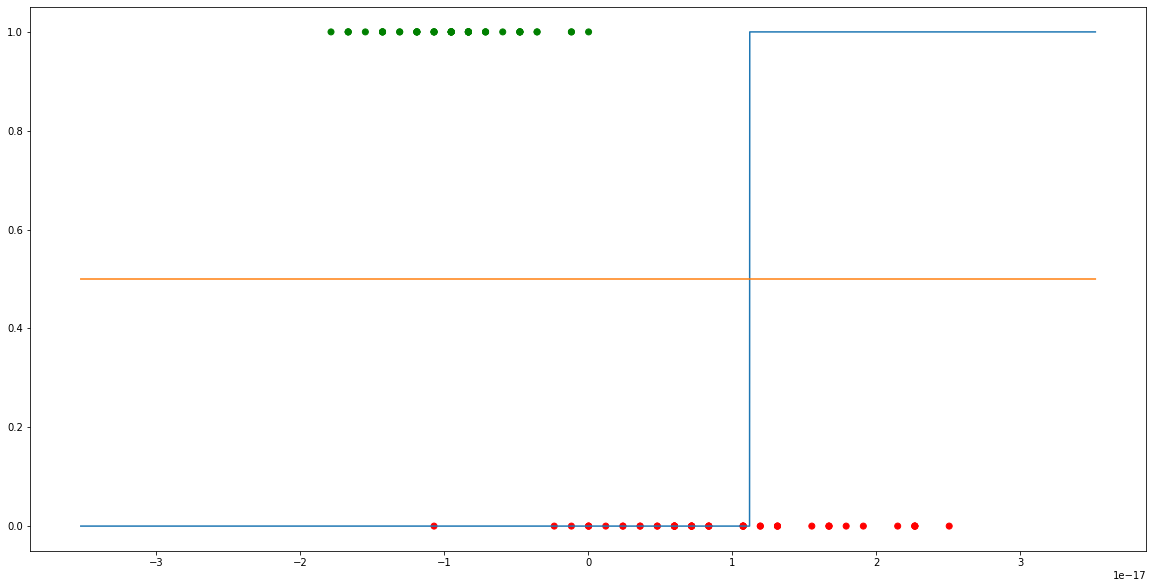

In [64]:
x_min_max = 3.5211233541225406e-17
x = np.linspace(-1*x_min_max, x_min_max, 10000)
fig = plt.figure(figsize=(20,10))
# Add 

for i in [postWeightVariance, postWeightVariance*1e31, ]:# * v for v in range(0, 10)]:
    y = cdf(x, postWeightMean, i)
    plt.plot(x,y, label=str(i))
plt.scatter(x=df_2_class.score, 
y=df_2_class['class'].map({'Iris-virginica':0, 'Iris-setosa':1}),
c=df_2_class['class'].map({'Iris-virginica':'red', 'Iris-setosa':'green'}))
fig.show()